<a href="https://colab.research.google.com/github/evillag/nlp/blob/main/tareas/t5/NLP_tarea_5_SVM_LSTM_VOEV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 5
## Curso: Procesamiento de Lenguaje Natural (NLP)
## Maestría en Computación
## Instituto Tecnológico de Costa Rica (ITCR)

Medio de entrega:  TecDigital.

Entregables: Un archivo jupyter con los ejercicios resueltos.

Modo de trabajo: individual o en grupos de máximo dos personas.

**Elaborado por**:


*   Victoria Orozco Arias. Carnet $2022438528$
*   Esteban Villalobos Gómez. Carnet $9913628$

**Fecha de entrega:** 27/09/2024


---



# Descripción

Twitter se ha convertido en un canal de comunicación importante en tiempos de emergencia. La ubicuidad de los teléfonos inteligentes permite a las personas anunciar una emergencia que están observando en tiempo real.

Debido a esto, cada vez hay más agencias interesadas en monitorear Twitter de manera automática (es decir, organizaciones de ayuda humanitaria y agencias de noticias). Sin embargo, no siempre está claro si las palabras de una persona realmente están anunciando un desastre. Por ejemplo, si alguien escribe:

> “Por el lado positivo, MIRA EL CIELO AL ATARDECER, ¡ESTABA EN LLAMAS!”

El autor utiliza explícitamente la frase “EN LLAMAS”, pero lo dice metafóricamente. Esto resulta evidente para cualquier persona de inmediato, especialmente si viene acompañado de una imagen.

Se deben construir y comparar los resultados obtenidos a partir de dos modelo de aprendizaje automático que predigan qué tweets tratan sobre desastres reales y cuáles no. Para esos modelos se usará Support Vector Machines (SVM) y Redes Recurrentes Long Short-Term Memory (LSTM). Se dispondrá de un conjunto de datos de 10 000 tweets que fueron clasificados manualmente.

Cada registro del conjunto de datos tiene las siguientes columnas con la información descrita:

- **id**: un identificador único para cada tweet
- **text**: el texto del tweet
- **location**: la ubicación desde la que se envió el tweet (puede estar en blanco)
- **keyword**: una palabra clave particular del tweet (puede estar en blanco)
- **target**: indica si un tweet trata sobre un desastre real (1) o no (0)


In [2]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pandas as pd
import numpy as np
import requests
import nltk
import re
import time

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from urllib.parse import unquote


# Use GPU si esta disponible
if torch.cuda.is_available():
  device = torch.device("cuda")
  print("Utilizando GPU")
else:
  device = torch.device("cpu")
  print("Utilizando CPU")

Utilizando GPU


# **A) Support Vector Machines (SVM)**

Escribir un cuaderno de Jupyter que realice las siguientes acciones. Puede basarse en el cuaderno sobre SVM visto en clase:
> Semana 05 Clasificación de texto – SVM

Debe asegurarse de que el cuaderno acceda al archivo de datos usando un path que no dependa de su máquina.


**Carga** (10 puntos)
### 1. Cargar el archivo 'tweets.csv' que se distribuye con este enunciado.


In [3]:
%rm tweets.csv

url = "https://raw.githubusercontent.com/evillag/nlp/refs/heads/main/tareas/t5/tweets.csv"
response = requests.get(url)

with open("tweets.csv", "wb") as f:
  f.write(response.content)

df = pd.read_csv('tweets.csv')
print(df.info())

# Limpieza de la columnas de texto

features = ['keyword', 'location', 'text']
for columna in features:
  df[columna] = df[columna].fillna('N/A')
  df[columna] = df[columna].apply(lambda x: unquote(x) if isinstance(x, str) else x)

df.sample(20)

rm: cannot remove 'tweets.csv': No such file or directory
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None


,id,keyword,location,text,target
2141,3073,deaths,Does it really matter!,Deaths 7 http://t.co/xRJA0XpL40,1
519,751,avalanche,guaravitas,we'll crash down like an avalanche,0
3730,5301,fear,"Bremerton, WA",The Walking Dead spin off Fear the Walking Dea...,1
7528,10766,wreckage,Mumbai,Wreckage 'Conclusively Confirmed' as From MH37...,1
2146,3080,deaths,Edinburgh,Had lunch with Stewart &amp; Julian only a cou...,0
585,845,bioterror,N/A,House Energy &amp;amp; Commerce subcommittee t...,1
2188,3136,debris,"Berlin, Germany",Experts leave lab as Malaysia confirms debris ...,1
2040,2929,danger,Atlanta Georgia,@bluebirddenver #FETTILOOTCH IS #SLANGLUCCI OP...,1
2601,3735,destroyed,"Boise, Idaho",70 years after #ABomb destroyd #HiroshimaÛÓ#B...,1
6479,9266,sunk,"Cardiff, Wales",@BenAffleck i respected you and liked you for...,0


### 2. Contar la frecuencia de las dos clases y calcular el porcentaje de cada clase.

In [4]:
# Conteo de la frecuencia de las clases en la columna target

class_counts = df['target'].value_counts()
print("Frecuencia de las clases:")
print(class_counts)

# Porcentaje de cada clase

class_percentages = (class_counts / len(df)) * 100
print("\nPorcentaje de las clases:")
print(class_percentages)


Frecuencia de las clases:
target
0    4342
1    3271
Name: count, dtype: int64

Porcentaje de las clases:
target
0    57.034021
1    42.965979
Name: count, dtype: float64


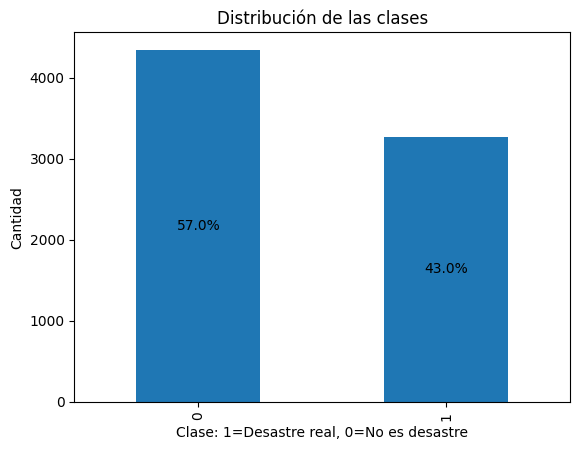

In [5]:
# Grafico de las clases

ax = df['target'].value_counts().plot(kind='bar')
plt.title('Distribución de las clases')
plt.xlabel('Clase: 1=Desastre real, 0=No es desastre')
plt.ylabel('Cantidad')

# Obtener los valores de las barras
totals = []
for i in ax.patches:
    totals.append(i.get_height())

# Configurar el formato del texto del porcentaje
total = sum(totals)
for i in ax.patches:
    # Obtener la altura de la barra
    height = i.get_height()
    # Calcular el porcentaje
    percentage = '{:.1f}%'.format(100 * height / total)
    # Agregar el texto al centro de la barra
    ax.text(i.get_x() + i.get_width() / 2., height / 2., percentage, ha='center', va='center', rotation=0)

plt.show()

### 3. Obtener la lista de stopwords para inglés.


In [6]:
nltk.download('stopwords')
swords = stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### 4. Calcular y mostrar la distribución de palabras para cada una de las clases. Antes de contar debe eliminar las palabras no útiles (stopwords)

In [7]:
for columna in features:
  # Elimina valores Nulos
  df[columna] = df[columna].apply(lambda x: x.replace('N/A', ''))

  # Convierte palabras a minúscula
  df[columna] = df[columna].apply(lambda x: x.lower())

  # Elimina links
  df[columna] = df[columna].apply(lambda x: re.sub(r'http\S+', '', x))

  # Limpia todo excepto caracteres alfanuméricos
  df[columna] = df[columna].apply(lambda x: re.sub("[^a-zA-Z0-9]"," ",x))

  # Elimina stopwords
  df[columna] = df[columna].apply(lambda x: ' '.join([word for word in x.split() if word not in swords]))
df.sample(20)

,id,keyword,location,text,target
3783,5373,fire truck,plain texas,brooktekle look like murder scene 1 cops fire ...,1
3955,5622,flooding,,flooding kills 166 displace one million pakist...,1
1234,1775,buildings fire,manchester nh,fire destroys two buildings 2nd street manchester,1
2606,3741,destroyed,,hot teen nsfw porn milf oiled ass hole destroy...,0
5196,7418,obliterated,wynne ar,rockbottomradfm kid remember hearing rules 30 ...,0
1751,2519,collision,maryland,baltimore city 95 north mp 54 8 fort mchenry t...,1
2412,3471,derailed,chicago il,new illustration l times illustration subway,0
3097,4445,electrocute,,links watch show better work might electrocute...,0
308,451,armageddon,,best movie ever seen armageddon,0
7153,10250,war zone,nashville tn,sitting still cityofmemphis traffic like sitti...,0


## **Pre-procesamiento** (5 puntos)


### 5. Separar la colección en un conjunto de entrenamiento y uno de prueba. Dar un 80% de los registros al conjunto de entrenamiento.


In [8]:
X = df[features]
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Tamaño del conjunto de entrenamiento:\t", X_train.shape)
print("Tamaño del conjunto de prueba:\t\t", X_test.shape)
print("Tamaño del conjunto de etiquetas de entrenamiento:\t", y_train.shape)
print("Tamaño del conjunto de etiquetas de prueba:\t\t", y_test.shape)


Tamaño del conjunto de entrenamiento:	 (6090, 3)
Tamaño del conjunto de prueba:		 (1523, 3)
Tamaño del conjunto de etiquetas de entrenamiento:	 (6090,)
Tamaño del conjunto de etiquetas de prueba:		 (1523,)


### 6. Convertir el conjunto de entrenamiento y el conjunto de pruebas a la representación requerida por el modelo SVM.

In [ ]:
# prompt: Cual es el formato de los conjuntos de entrenamiento y pruebas que se requieren para entrenar un modelo sklearn.svm.SVC?

# Los conjuntos de entrenamiento y prueba para sklearn.svm.SVC deben tener la siguiente estructura:

# X_train: Una matriz NumPy o una lista de listas, donde cada fila representa un ejemplo de entrenamiento y cada columna representa una característica.
# y_train: Una matriz NumPy o una lista de etiquetas correspondientes a cada ejemplo de entrenamiento en X_train.
# X_test: Una matriz NumPy o una lista de listas, donde cada fila representa un ejemplo de prueba y cada columna representa una característica.
# y_test: Una matriz NumPy o una lista de etiquetas correspondientes a cada ejemplo de prueba en X_test.

# En resumen, X_train y X_test deben ser matrices de características, e y_train y y_test deben ser vectores de etiquetas.

# Ejemplo:

# X_train = [[1, 2, 3], [4, 5, 6], [7, 8, 9]]
# y_train = [0, 1, 0]
# X_test = [[10, 11, 12], [13, 14, 15]]
# y_test = [1, 0]

# En este caso, cada ejemplo tiene 3 características y las etiquetas son 0 o 1.


# Para el caso de su proyecto, primero necesita convertir los datos de texto (tweets) a una representación numérica que pueda ser utilizada por el modelo SVM.
# Podría usar TF-IDF o Word2Vec para realizar esta conversión.

# Una vez que tenga la representación numérica de los tweets, puede crear las matrices X_train, X_test, y_train y y_test y luego entrenar su modelo SVM utilizando sklearn.svm.SVC.


In [9]:
# Combina las columnas de texto en una sola columna
X_train['combined_text'] = X_train['keyword'] + ' ' + X_train['location'] + ' ' + X_train['text']
X_test['combined_text'] = X_test['keyword'] + ' ' + X_test['location'] + ' ' + X_test['text']

In [10]:
"""Se debe convertir cada columna textual a una representacion numérica (vectorizacion) para poder entrenar un
clasificador SVM.

En el jupyter de la clase 5 usan Bag of Words, tambien se podria usar TF-IDF o Word2Vec para realizar esta conversión.
"""

# Vectorizacion con Bag of Words
vectorizer = CountVectorizer(max_features=50000)

X_train_bow = vectorizer.fit_transform(X_train['combined_text']).toarray()
X_test_bow = vectorizer.transform(X_test['combined_text']).toarray()

print(X_train_bow.shape)
print(X_test_bow.shape)
print(vectorizer.get_feature_names_out())


(6090, 16230)
(1523, 16230)
['00' '000' '0000' ... 'zumiez' 'zwe' 'zzzz']


## **Experimentos** (10 puntos)

### 7. Implementar y entrenar un clasificador usando SVM.

In [ ]:
# Crea un clasificador SVC
svm_classifier = SVC(kernel='linear')

# Registra el tiempo de inicio
start_time = time.time()

# Entrena el clasificador
svm_classifier.fit(X_train_bow, y_train)

# Registra el tiempo de finalización
end_time = time.time()

# Calcula la duración del entrenamiento
training_time = end_time - start_time

print(f"El entrenamiento tomó {training_time:.2f} segundos.")



### 8. Obtener predicciones del modelo SVM usando el conjunto de prueba.

In [ ]:
y_pred = svm_classifier.predict(X_test_bow)

## **Evaluación** (5 puntos)


### 9. Obtener los valores de precisión, recall, f1-score y acierto para el modelo. Tanto globales como por clase.

In [ ]:
# Precisión, recall, f1-score y acierto globales
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Métricas globales:")
print("Precisión:", accuracy)
print("Recall:", recall)
print("F1-score:", f1)
print("Acierto:", accuracy)


# Precisión, recall, f1-score y acierto por clase
print("\nMétricas por clase:")
print(classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
print("\nMatriz de confusión:")
print(cm)


### 10. Comentar los resultados obtenidos.

# **B) Long Short-Term Memory (LSTM)**



## **Pre-procesamiento** (5 puntos)


### 11. Utilice las mismas particiones de entrenamiento y pruebas obtenidas en el ejercicio A)


### 12. Convertir el conjunto de entrenamiento y el conjunto de pruebas a la representación requerida por el modelo LSTM.

## **Experimentos** (10 puntos)

### 13. Utilice la biblioteca Pytorch para implementar y entrenar un clasificador usando una red recurrente LSTM.


### 14. Durante el entrenamiento grafique la curva de error, explique los resultados obtenidos en gráfica y ajuste el modelo o el proceso de entrenamiento apropiadamente (por ejemplo, verifique que el modelo no esté sobre-ajustado).


### 15. Obtener predicciones del modelo LSTM usando el conjunto de prueba.

## **Evaluación** (5 puntos)


### 16. Obtener los valores de precisión, recall, f1-score y acierto para el modelo. Tanto globales como por clase.


## 17. Comente y compare los resultados obtenidos con SVM y LSTM.